In [128]:
!pip install pyspark

Данные разделены на две группы:

- Обучающая выборка (train.csv)
- Тестовая выборка (test.csv)

Обучающая выборка должна использоваться для построения ваших моделей машинного обучения. Для обучающей выборки мы предоставляем результат (также известный как "истинное значение") для каждого пассажира. Ваша модель будет основываться на "признаках", таких как пол и класс пассажиров. Вы также можете использовать инжиниринг признаков для создания новых признаков.

Тестовая выборка должна использоваться для проверки того, насколько хорошо ваша модель работает на невидимых данных. Для тестовой выборки мы не предоставляем истинные значения для каждого пассажира. Ваша задача — предсказать эти результаты. Для каждого пассажира в тестовой выборке используйте модель, которую вы обучили, чтобы предсказать, выжил он при крушении Титаника или нет.

Также мы включили файл gender_submission.csv, который содержит набор прогнозов, предполагающий, что все и только женщины-пассажиры выжили. Это пример того, как должен выглядеть файл с результатами.

Ссылка: https://www.kaggle.com/competitions/titanic/data

In [129]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import pyspark
%matplotlib inline

from pyspark.sql import SparkSession, SQLContext
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, QuantileDiscretizer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, RegressionEvaluator, BinaryClassificationEvaluator
from pyspark.sql.functions import isnan, when, count, col, regexp_extract
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit, CrossValidator
from sklearn.metrics import roc_curve, auc

In [130]:
spark = SparkSession.builder.appName('Titanic_PySpark').getOrCreate()
train_path = '/content/train.csv'
data = spark.read.csv(train_path, header='True', inferSchema='True')
data.show(5)

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| NULL|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| NULL|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| NULL|       S|
+-----------+--------+------+--------------------+------+----+-----+-----+------

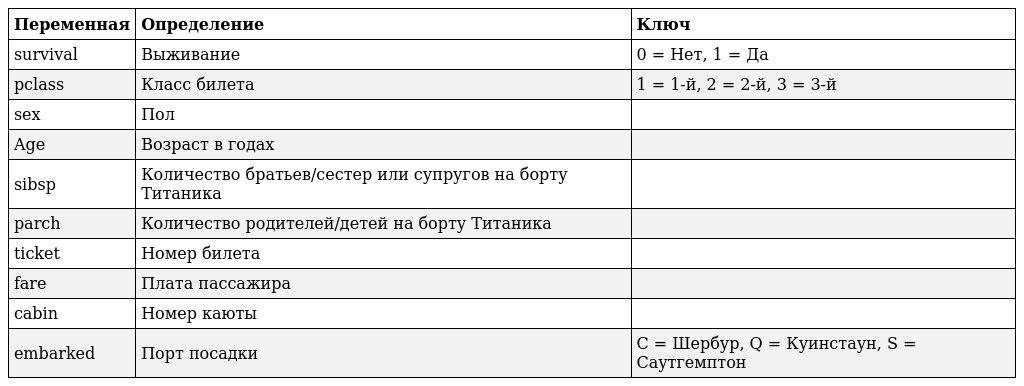

In [131]:
data.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



In [132]:
data.count()

891

<ipython-input-133-4499a6a44b36>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_pd['Age'])


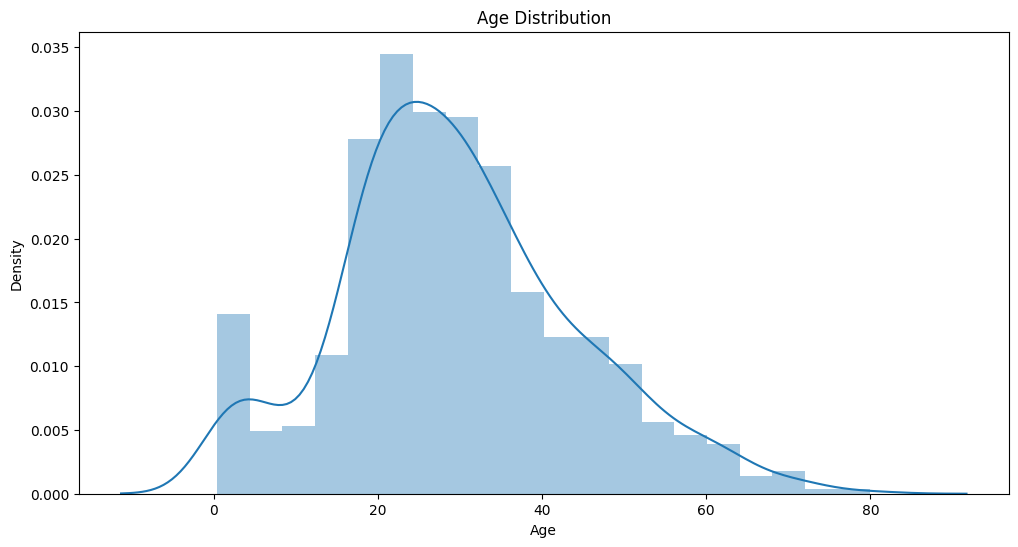

In [133]:
data_pd = data.toPandas()

plt.figure(figsize=(12, 6))
sns.distplot(data_pd['Age'])
plt.title('Age Distribution')
plt.show()

Проверим на наличии пропусков.

In [134]:
data.select([
    count(when(isnan(column) | col(column).isNull(), column)).alias(column) \
    for column in data.columns
]).show()

+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|          0|       0|     0|   0|  0|177|    0|    0|     0|   0|  687|       2|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+



In [135]:
data = data.drop('Cabin')
data = data.withColumn('Initial', regexp_extract(col('Name'), '([A-Za-z]+)\.', 1))
data.show(5)

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+--------+-------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Embarked|Initial|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+--------+-------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25|       S|     Mr|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|       C|    Mrs|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925|       S|   Miss|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1|       S|    Mrs|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05|       S|     Mr|
+-----------+--------+------+--------------------+------+----+--

In [136]:
data.groupby('Initial').count().collect()

[Row(Initial='Don', count=1),
 Row(Initial='Miss', count=182),
 Row(Initial='Countess', count=1),
 Row(Initial='Col', count=2),
 Row(Initial='Rev', count=6),
 Row(Initial='Lady', count=1),
 Row(Initial='Master', count=40),
 Row(Initial='Mme', count=1),
 Row(Initial='Capt', count=1),
 Row(Initial='Mr', count=517),
 Row(Initial='Dr', count=7),
 Row(Initial='Mrs', count=125),
 Row(Initial='Sir', count=1),
 Row(Initial='Jonkheer', count=1),
 Row(Initial='Mlle', count=2),
 Row(Initial='Major', count=2),
 Row(Initial='Ms', count=1)]

In [137]:
data = data.replace(
    ['Mlle', 'Mme', 'Ms', 'Dr', 'Major', 'Lady', 'Countess', 'Jonkheer', 'Col', 'Rev', 'Capt', 'Sir', 'Don'],
    ['Miss', 'Miss', 'Miss', 'Mr', 'Mr', 'Mrs', 'Mrs', 'Other', 'Other', 'Other', 'Mr', 'Mr', 'Mr']
)
data.groupby('Initial').count().show(5)

+-------+-----+
|Initial|count|
+-------+-----+
|   Miss|  186|
|  Other|    9|
| Master|   40|
|     Mr|  529|
|    Mrs|  127|
+-------+-----+



In [138]:
data_count = data.groupBy('Initial').avg('Age').withColumnRenamed('avg(Age)', 'mean')
data_count = data_count.withColumn('mean', pyspark.sql.functions.round(data_count['mean']))
data_count.show()

+-------+----+
|Initial|mean|
+-------+----+
|   Miss|22.0|
|  Other|46.0|
| Master| 5.0|
|     Mr|33.0|
|    Mrs|36.0|
+-------+----+



In [139]:
for i in range(5):
    data = data.withColumn('Age',
        when((data['Initial'] == data_count.collect()[i][0]) & \
             (data['Age'].isNull()), data_count.collect()[i][1]) \
        .otherwise(data['Age']))
data.show()

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+--------+-------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Embarked|Initial|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+--------+-------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25|       S|     Mr|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|       C|    Mrs|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925|       S|   Miss|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1|       S|    Mrs|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05|       S|     Mr|
|          6|       0|     3|    Moran, Mr. James|  male|33.0|  

In [140]:
data.groupBy("Embarked").count().show()

+--------+-----+
|Embarked|count|
+--------+-----+
|       Q|   77|
|    NULL|    2|
|       C|  168|
|       S|  644|
+--------+-----+



In [141]:
data = data.na.fill({'Embarked': 'S'})
data.select([
    count(when(isnan(column) | col(column).isNull(), column)).alias(column) \
    for column in data.columns
]).show()

+-----------+--------+------+----+---+---+-----+-----+------+----+--------+-------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Embarked|Initial|
+-----------+--------+------+----+---+---+-----+-----+------+----+--------+-------+
|          0|       0|     0|   0|  0|  0|    0|    0|     0|   0|       0|      0|
+-----------+--------+------+----+---+---+-----+-----+------+----+--------+-------+



In [142]:
# Feature engineering
data = data.withColumn('Family_size', col('SibSp') + col('Parch'))

# converting Sex, Embarked and Initial columns from string to number using StringIndexer
indexers = [StringIndexer(
    inputCol=column, outputCol=column + '_index').fit(data)
    for column in ['Sex', 'Embarked', 'Initial']
]
data = Pipeline(stages=indexers).fit(data).transform(data)


data = data.drop("PassengerId", "Name", "Ticket", "Cabin", "Embarked", "Sex", "Initial")
feature = VectorAssembler(inputCols=data.columns[1:], outputCol='features')
feature_vector = feature.transform(data)
feature_vector.show(5)

+--------+------+----+-----+-----+-------+-----------+---------+--------------+-------------+--------------------+
|Survived|Pclass| Age|SibSp|Parch|   Fare|Family_size|Sex_index|Embarked_index|Initial_index|            features|
+--------+------+----+-----+-----+-------+-----------+---------+--------------+-------------+--------------------+
|       0|     3|22.0|    1|    0|   7.25|          1|      0.0|           0.0|          0.0|[3.0,22.0,1.0,0.0...|
|       1|     1|38.0|    1|    0|71.2833|          1|      1.0|           1.0|          2.0|[1.0,38.0,1.0,0.0...|
|       1|     3|26.0|    0|    0|  7.925|          0|      1.0|           0.0|          1.0|[3.0,26.0,0.0,0.0...|
|       1|     1|35.0|    1|    0|   53.1|          1|      1.0|           0.0|          2.0|[1.0,35.0,1.0,0.0...|
|       0|     3|35.0|    0|    0|   8.05|          0|      0.0|           0.0|          0.0|(9,[0,1,4],[3.0,3...|
+--------+------+----+-----+-----+-------+-----------+---------+--------------+-

In [143]:
train_test_data = feature_vector.select(['features', 'Survived'])
train_data, test_data = train_test_data.randomSplit([0.8, 0.2])

In [144]:
log_reg = LogisticRegression(labelCol='Survived')
param_grid = ParamGridBuilder() \
    .addGrid(log_reg.regParam, (0.01, 0.1)) \
    .addGrid(log_reg.maxIter, (5, 10)) \
    .addGrid(log_reg.tol, (1e-5, 1e-4)) \
    .addGrid(log_reg.elasticNetParam, (0.25, 0.75)) \
    .build()
model = TrainValidationSplit(
    estimator=log_reg,
    estimatorParamMaps=param_grid,
    evaluator=MulticlassClassificationEvaluator(labelCol='Survived'),
    trainRatio=0.8
).fit(train_data)
log_reg_pred = model.transform(test_data)

print(f"Accuracy:  {MulticlassClassificationEvaluator(labelCol='Survived',metricName='accuracy').evaluate(log_reg_pred)}")
print(f"Precision: {MulticlassClassificationEvaluator(labelCol='Survived',metricName='weightedPrecision').evaluate(log_reg_pred)}")
print(f"Recall:    {MulticlassClassificationEvaluator(labelCol='Survived',metricName='weightedRecall').evaluate(log_reg_pred)}")

Accuracy:  0.8011363636363636
Precision: 0.7983471074380166
Recall:    0.8011363636363636


In [145]:
def roc_curve_plot(model_pred):
    preds = model_pred.select(['probability', 'Survived']).collect()
    preds = [(float(pred[0][0]), 1.0 - float(pred[1])) for pred in preds]

    y_pred = [pred[0] for pred in preds]
    y_test = [pred[1] for pred in preds]

    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    print(f'ROC AUC: {roc_auc}')

    plt.figure(figsize=(12, 8))
    plt.plot(fpr, tpr, label=f'ROC Curve (Area = {round(roc_auc, 4)})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Area under the ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

ROC AUC: 0.8223353794642858


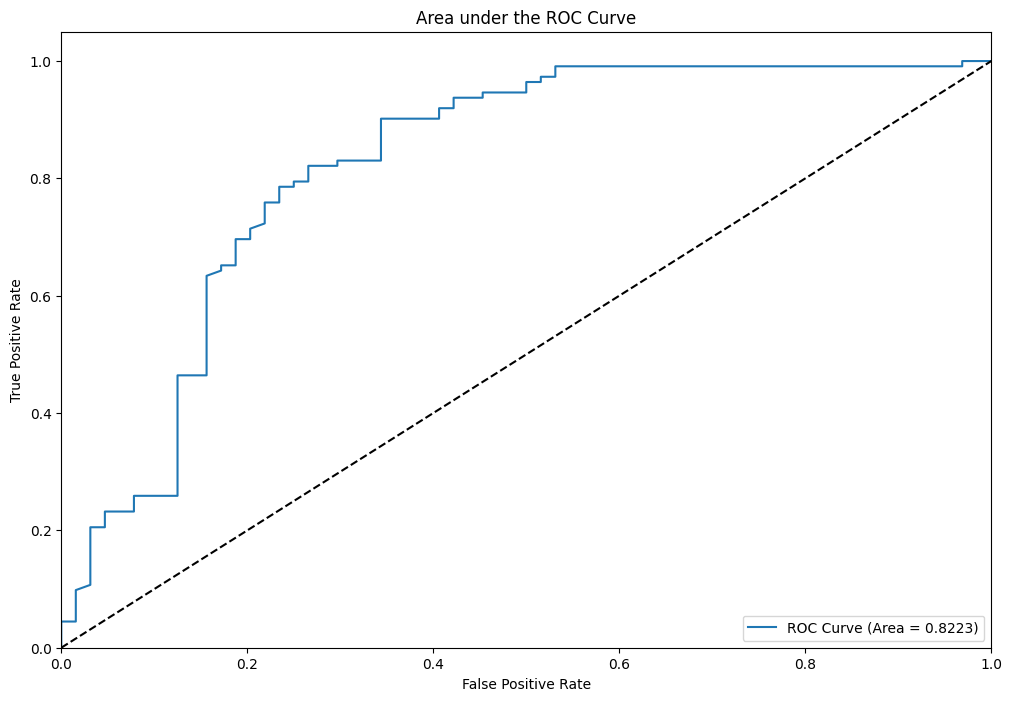

In [146]:
roc_curve_plot(log_reg_pred)

In [147]:
rf_model = RandomForestClassifier(labelCol='Survived')
param_grid = ParamGridBuilder() \
    .addGrid(rf_model.maxDepth, [4, 6, 8, 10]) \
    .addGrid(rf_model.maxBins, [20, 35, 50]) \
    .addGrid(rf_model.numTrees, [20, 40, 60]) \
    .addGrid(rf_model.impurity, ['gini', 'entropy']) \
    .addGrid(rf_model.minInstancesPerNode, [1, 4, 7]) \
    .build()
model = TrainValidationSplit(
    estimator=rf_model,
    estimatorParamMaps=param_grid,
    evaluator=MulticlassClassificationEvaluator(labelCol='Survived'),
    trainRatio=0.8
).fit(train_data)
rf_pred = model.transform(test_data)

print(f"Accuracy:  {MulticlassClassificationEvaluator(labelCol='Survived',metricName='accuracy').evaluate(rf_pred)}")
print(f"Precision: {MulticlassClassificationEvaluator(labelCol='Survived',metricName='weightedPrecision').evaluate(rf_pred)}")
print(f"Recall:    {MulticlassClassificationEvaluator(labelCol='Survived',metricName='weightedRecall').evaluate(rf_pred)}")

Accuracy:  0.7954545454545454
Precision: 0.7949810606060606
Recall:    0.7954545454545455


ROC AUC: 0.831263950892857


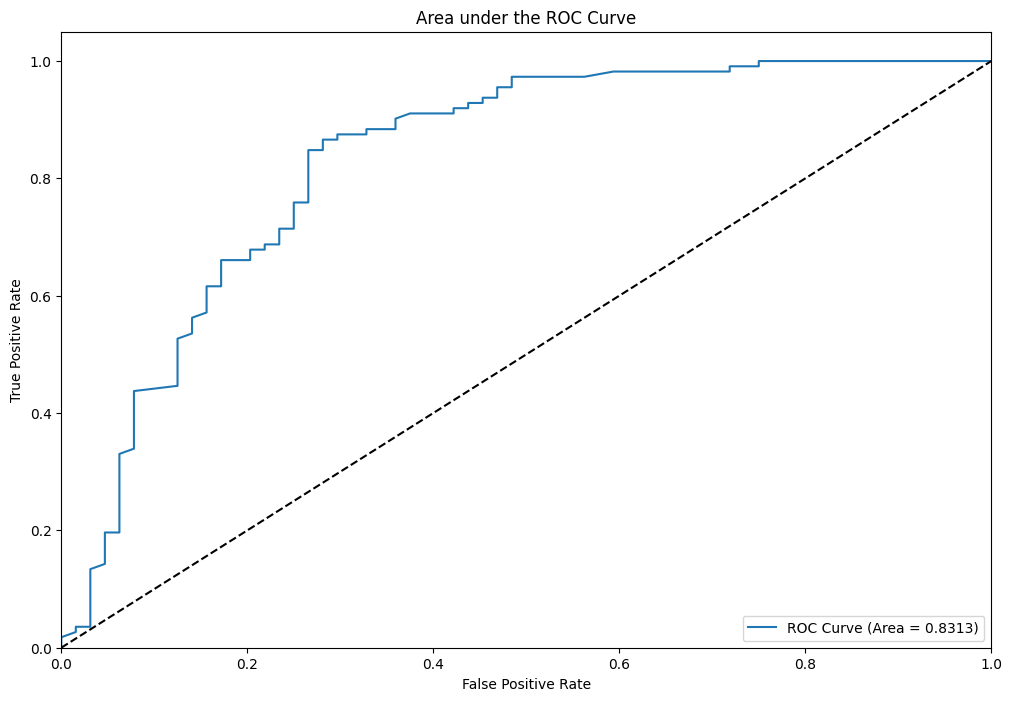

In [148]:
roc_curve_plot(rf_pred)

In [150]:
gbt_model = GBTClassifier(labelCol='Survived').fit(train_data)
gbt_pred = gbt_model.transform(test_data)

print(f"Accuracy:  {MulticlassClassificationEvaluator(labelCol='Survived',metricName='accuracy').evaluate(gbt_pred)}")
print(f"Precision: {MulticlassClassificationEvaluator(labelCol='Survived',metricName='weightedPrecision').evaluate(gbt_pred)}")
print(f"Recall:    {MulticlassClassificationEvaluator(labelCol='Survived',metricName='weightedRecall').evaluate(gbt_pred)}")

Accuracy:  0.8068181818181818
Precision: 0.8060606060606061
Recall:    0.8068181818181819


ROC AUC: 0.7696707589285714


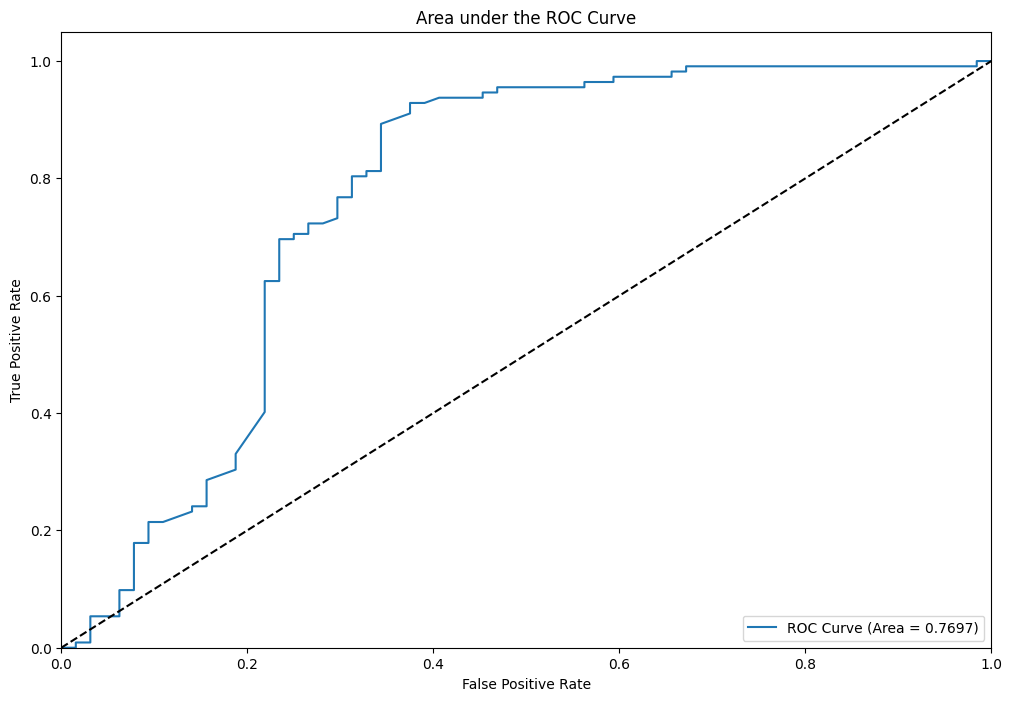

In [151]:
roc_curve_plot(gbt_pred)